# Proyecto 03 - Procesamiento del Lenguaje Natural

## Objetivo

**Implementa un modelo para reconocer el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.**

## Dataset: The Multilingual Amazon Reviews Corpus

Dataset: [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

***Vamos a importar las librerias que vamos a manejar***

In [1]:
!pip install pandas-profiling[notebook]

In [2]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
stop_words = set(nltk.corpus.stopwords.words('spanish'))
from nltk.tokenize import RegexpTokenizer
import pandas_profiling as pdp
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import es_core_news_sm
import re
from unicodedata import normalize
import gc
gc.enable()
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline 
    sns.set(color_codes=True)
    sns.set()

### **Cargamos los datasets**

In [5]:
dataset_dev = pd.read_json('C:/Users/Gabriel/OneDrive/Documentos/OneDrive/DATA SCIENCE/PROYECTOS/Proyecto3/NLP/dataset_amazon/dataset_es_dev.json', lines= True)
dataset_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [6]:
dataset_test = pd.read_json('C:/Users/Gabriel/OneDrive/Documentos/OneDrive/DATA SCIENCE/PROYECTOS/Proyecto3/NLP/dataset_amazon/dataset_es_test.json', lines= True)
dataset_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [7]:
dataset_train = pd.read_json('C:/Users/Gabriel/OneDrive/Documentos/OneDrive/DATA SCIENCE/PROYECTOS/Proyecto3/NLP/dataset_amazon/dataset_es_train.json', lines= True)
dataset_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


**Vemos cuantas filas y columnas tienen los dataset**

In [8]:
dataset_dev.shape

(5000, 8)

In [9]:
dataset_test.shape

(5000, 8)

In [10]:
dataset_train.shape

(200000, 8)

**Con el fin simplificar el procesamiento  de nuestros dataset vamos a unir los datos ya que poseen la misma información**



In [11]:
data=pd.concat([dataset_dev, dataset_test, dataset_train], axis=0)
data.shape

(210000, 8)

**Revisemos detalladamente nuestro dataset**

In [12]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


**Verificamos si se generaron filas duplicadas**

In [13]:
duplicate_rows_df = data[data.duplicated()]
print('number of duplicate rows:', duplicate_rows_df.shape)

number of duplicate rows: (0, 8)


In [14]:
# visualizamos la información de nuestro nuevo dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.4+ MB


In [15]:
# vemos los nombres de las columnas
data.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

In [16]:
# vemos si hay datos nulos
data.isnull().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

**Cantidad de estrellas por critica**

In [17]:
# vemos el cantidad de reviews calificados con 1, 2, 3, 4 o 5 estrellas
data['stars'].value_counts()

1    42000
2    42000
3    42000
4    42000
5    42000
Name: stars, dtype: int64

**En nuestro dataset las etiquetas serán el número de estrellas, como podemos ver están balanceadas**

**Revisemos la distribucion en porcentaje de las estrellas**

**Promedio de estrellas por producto**

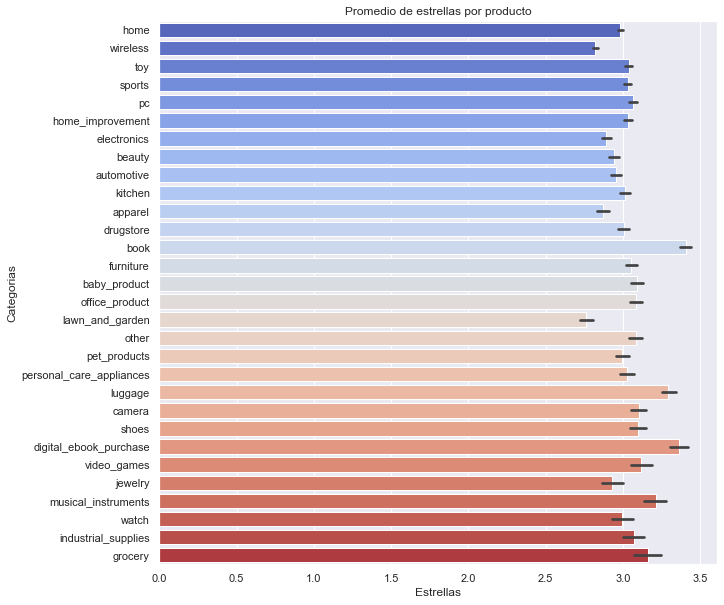

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x='stars', y='product_category' ,
            data=data, palette= 'coolwarm',
            order = data.product_category.value_counts().index)
plt.ylabel("Categorias")
plt.xlabel("Estrellas")
plt.title("Promedio de estrellas por producto")
plt.show()

**Es interesante que los productos que más calificaciones positivas reciben son libros y equipaje. En el otro extremo con calificaciones más bajas están los productos de indumentaria(apparel), jardinería(garden) y wireless**

**Cantidad de reviews segun producto**

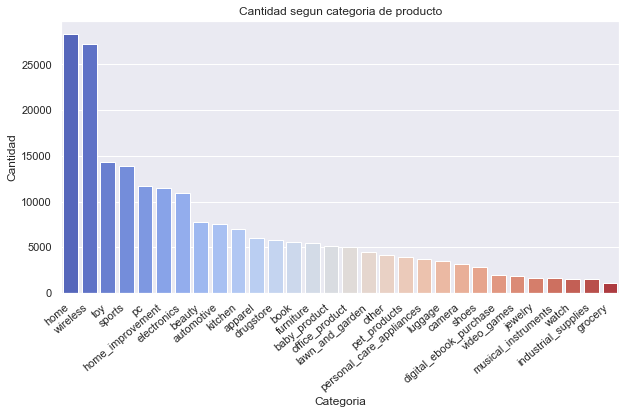

In [19]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data = data, x = "product_category", palette= 'coolwarm',
                   order = data.product_category.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")
plt.ylabel("Cantidad")
plt.xlabel("Categoria")
plt.title("Cantidad segun categoria de producto")
plt.show()

**Porcentaje del total de productos**

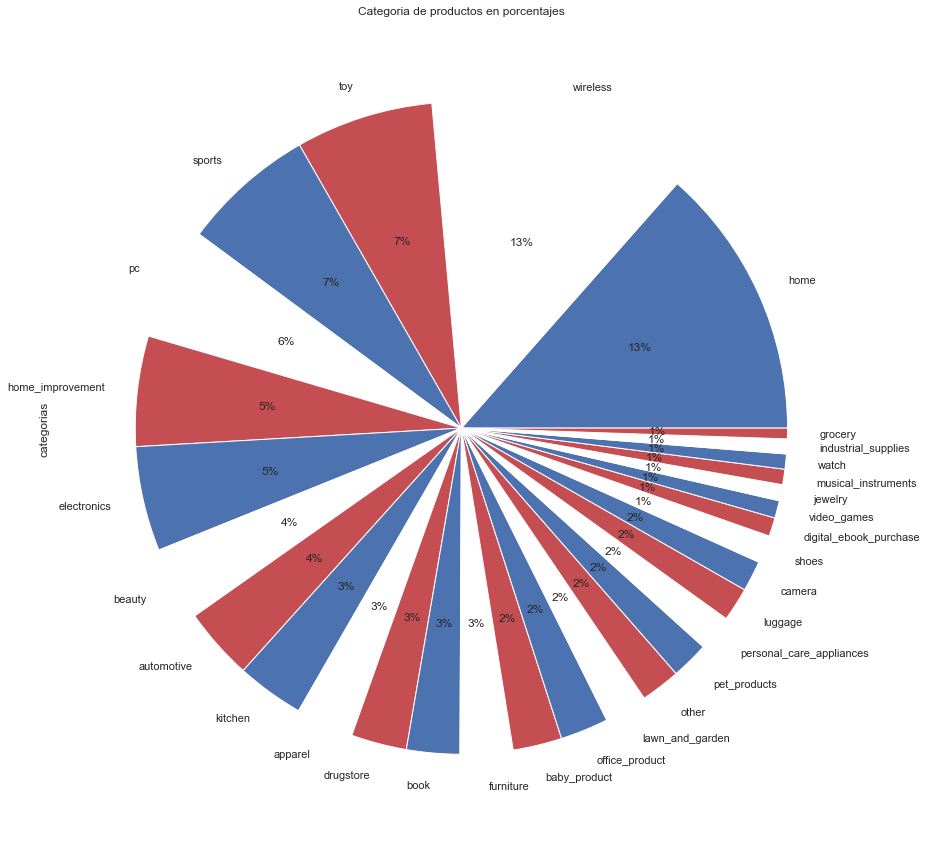

In [20]:
plt.figure(figsize=(22,15))
data.product_category.value_counts().plot(kind="pie", autopct='%1.0f%%', colors='bwr')
plt.ylabel("categorias")
plt.title("Categoria de productos en porcentajes")
plt.show()

**Destacan los productos del hogar "HOME" y productos de conectividad inalambrica "WIRELESS"**

### PRE-PROCESAMIENTO DE DATOS

In [21]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [22]:
data.shape

(210000, 8)

Chequeamos que no hayan quedado valores nulos

In [23]:
data.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

**Columnas de un solo valor**

La única columna que parece tener un valor único es la denominada "language", vamos a chequearlo. 

In [24]:
print(data.language.unique())

['es']


**Cantidad de valores únicos por columna**

In [25]:
for i in range(data.shape[1]):
    print(i,len(pd.unique(data.iloc[:,i])))

0 210000
1 156458
2 187140
3 5
4 208127
5 117156
6 1
7 30


**Cantidad de información en porcentaje, por columna**

In [26]:
for i in range(data.shape[1]):
    num=len(pd.unique(data.iloc[:,i]))
    porcentaje=float(num)/data.shape[0]*100
    print("%d, %d, %.1f%%"%(i,num,porcentaje))

0, 210000, 100.0%
1, 156458, 74.5%
2, 187140, 89.1%
3, 5, 0.0%
4, 208127, 99.1%
5, 117156, 55.8%
6, 1, 0.0%
7, 30, 0.0%


**Datos duplicados**

**Eliminamos las columnas con poca información**

In [27]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


**Como voy a trabajar solo son "review_body" elimino "review_title"  y el tipo de producto no aporta al análsis así que también lo elimino. 

In [28]:
data=data.drop(["review_id","product_id","reviewer_id","language", "review_title", 'product_category'],axis=1)

In [29]:
data.head()

,stars,review_body
0,1,"Malisimo, muy grande demasiado aparatoso y mal..."
1,1,No he recibido el pedido no la devolución
2,1,"Tengo que buscar otro sistema, este no funcion..."
3,1,Utilicé las brocas de menor diámetro y se me d...
4,1,No me gusta su olor a viejo y aspecto malo


### TRANSFORMACIONES DEL TEXTO

###  1. Haz todas las transformaciones de datos que consideres necesarias.

A) Eliminar todo aquello que no sean letras. Objetivo: Eliminacion de signos o caracteres especiales y números.

B) Llevar todas las palabras a minuscula. Objetivo: Reducir el trabajo al analizar el texto con palabras que significan lo mismo pero algunas utilizan mayusculas y otras no segun el contexto.
 
C) Eliminar palabras con menos de 3 letras

D) Dividir las palabras en TOKENS

E) Utilizacion de stopwords. Objetivo: eliminar las palabras con poco valor para el analisis.


In [30]:
import re, string, unicodedata
def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

In [31]:
import unicodedata
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [32]:
titular_list=[]

for titular in data.review_body:
   
    # Vamos a reemplazar los caracteres que no sean letras por espacios o números
    titular=clean_text(titular)
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Quitamos los tildes
    titular= strip_accents(titular)
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stop_words]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)

In [33]:
data["rev_clean"]= titular_list

In [34]:
data.tail(10)

,stars,review_body,rev_clean
199990,5,Muy bueno y materiales muy bien. Facil de empa...,bueno materiales bien facil emparejar propio m...
199991,5,Mi gato pesa 5 kg y entra perfectamente. Muy p...,gato pesa entra perfectamente practico comodo ...
199992,5,"Muy buen producto , juego muy divertido y entr...",buen producto juego divertido entretenido
199993,5,"Si la primera parte me gustó, el desenlace me ...",primera parte gusto desenlace maravillado tant...
199994,5,Funcional. Buena calidad/precio.,funcional buena calidadprecio
199995,5,Mando funciona perfectamente y cumple con toda...,mando funciona perfectamente cumple todas func...
199996,5,"Compré la batería con cierta reticencia, pero ...",compre bateria cierta reticencia resulto facil...
199997,5,Buena calidad. Satisfecha con la compra.,buena calidad satisfecha compra
199998,5,Perfecto para el cumple de mi hijo,perfecto cumple hijo
199999,5,"Súper bien! Las brochas son buenas, no sé meno...",super bien brochas buenas menos caido pelitos ...


LEMMATIZER

A diferencia del lemmatizador en inglés, el lemmatizador español de SpaCy no utiliza de los información PoS Tag. Por el contrario, se basa en una lista de búsqueda de verbos y lemas (por ejemplo, ideo idear, ideas idear, idea idear, ideamos idear, etc). Simplemente emitirá la primera coincidencia en la lista, independientemente de su PoS.

https://stackoverflow.com/questions/60534999/how-to-solve-spanish-lemmatization-problems-with-spacy

In [35]:
import spacy
nlp = spacy.load('es_core_news_sm')

def lemmatizer(text):  
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc])

In [36]:
data['rev_clean'] = data['rev_clean'].apply(lambda x: lemmatizer(x))

In [37]:
data.rename(columns = {'rev_clean':'rev_lema'}, inplace = True)

In [38]:
data.tail(40)

,stars,review_body,rev_lema
199960,5,Muy buenos protectores y además en una caja mu...,buen protector adema cajo chular tipo accesori...
199961,5,"cumple su funcion, que no es poco, util, el en...",cumplir funcion util envio rapido llego perfec...
199962,5,Genial para la cámara,genial camar
199963,5,Es perfecto tal y como se describe,perfecto describir
199964,5,Este producto es muy eficiente y funciona como...,producto eficiente funcionar describir sellado...
199965,5,"tallan algo grande, pero están bien. Buenos ac...",tallar grande estir bien buen acabado comodo p...
199966,5,Excelente aparato para la recuperación de las ...,excelente aparato recuperacion pierna despu du...
199967,5,"Cumple la función muy bien, y el material es d...",cumplir funcion bien material duro foto sorpre...
199968,5,"Estoy muy contento con la compra, lo compre pa...",contento compra compre mujer verdad acertir to...
199969,5,Funciona muy bien he llegado a calentar el agu...,funcionar bien llegado calentar agua incluso d...


Auque el lematizador de Spacy comente algunos errores en general cumple su función llevando las palabras a su raiz semantica. También transforma las palabras a su forma singular. Saca algunas palabras que podrían ser útiles en el análisis como "tardar", la palabra compré no lapasa a su formaa raiz comprar.

**VAMOS ANALIZAR LAS FRECUENCIA DE LAS PALABRAS LUEGO DEL PRE-PROCESAMIENTO**

In [39]:
data_frec = data.dropna(subset=["rev_lema"])
data_frec['rev_lema']=data_frec['rev_lema'].apply(str)

In [40]:
words_lema= []
regexp=RegexpTokenizer(r"\w+")

for i in range(data_frec.shape[0]):
    x = data_frec.iloc[i].rev_lema
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    words_lema.append(x) 

In [41]:
words=[line for line in  words_lema for line in set(line)]
words= Counter(words)
words= words.most_common(50)
words=pd.DataFrame(words,columns = ['Words', 'Frequency'])
words.head(50)

,Words,Frequency
0,bien,46361
1,él,31610
2,buen,29822
3,calidad,29388
4,producto,23937
5,poder,21876
6,precio,20729
7,hacer,19342
8,funcionar,15250
9,quedar,13274


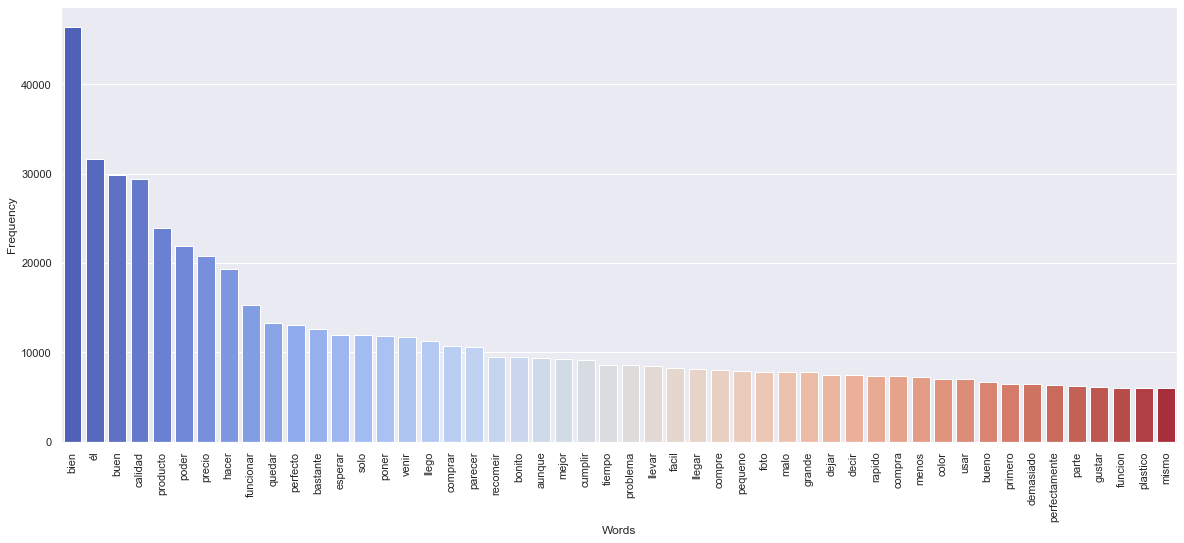

In [42]:
plt.figure(figsize = (20,8))
plot = sns.barplot(x  = words['Words'] , y = words['Frequency'],  palette= 'coolwarm')
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Como podemos ver a pesar de haber hecho un exaustivo pre-procesamiento siguen quedando palabras de poca relevancia con una alta frecuencia. Vamos armar una lista con estas palabras para sacarlas del corpus.  

In [43]:
new_list= ['él', 'producto', 'poder', 'hacer', 'solo', 'llegar', 'comprar', 'poner', 'recomeir', 'venir', 'llegado', 'quedar', 'decir', 'parecer', 'dejar', 'compre', 'primero', 'mes', 'menos', 'días', 'despu', 'compra', 'llevar', 'mismo', 'semana']  

In [44]:
corr_list=[]

for titular in data.rev_lema:
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in new_list]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    corr_list.append(titular)

In [45]:
data["rev_corr"]= corr_list

In [46]:
data.head(20)

,stars,review_body,rev_lema,rev_corr
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",malisimo grande demasiado aparatoso protector ...,malisimo grande demasiado aparatoso protector ...
1,1,No he recibido el pedido no la devolución,recibido pedido devolucion,recibido pedido devolucion
2,1,"Tengo que buscar otro sistema, este no funcion...",buscar sistema funcionar bien abrazaderar llev...,buscar sistema funcionar bien abrazaderar agar...
3,1,Utilicé las brocas de menor diámetro y se me d...,utilizar broca menor diametro doblar varios ma...,utilizar broca menor diametro doblar varios ma...
4,1,No me gusta su olor a viejo y aspecto malo,gustar olor viejo aspecto malo,gustar olor viejo aspecto malo
5,1,"Hola, después de recoger el paquete me ha lleg...",hola despues recoger paquete llegado bolo rota,hola despues recoger paquete bolo rota
6,1,"A parte de no poder elegir color, te envian el...",parte poder elegir color enviar cesto color im...,parte elegir color enviar cesto color imagino ...
7,1,Muy baja calidad de ahí si precio. Esta compra...,bajo calidad precio compra suponer tirar dinero,bajo calidad precio suponer tirar dinero
8,1,El producto sale como entregado pero yo no he ...,producto salir entregado recibido,salir entregado recibido
9,1,"No lo recomiendo, no se pega y acaba despegandose",recomeir pega acabar despegar él,pega acabar despegar


**Volvemos hacer una revisión de las 50 palabras más frecuentes**

In [47]:
data_frec = data.dropna(subset=["rev_corr"])
data_frec['rev_corr']=data_frec['rev_corr'].apply(str)

In [48]:
words_lema= []
regexp=RegexpTokenizer(r"\w+")

for i in range(data_frec.shape[0]):
    x = data_frec.iloc[i].rev_corr
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    words_lema.append(x) 

In [49]:
words=[line for line in  words_lema for line in set(line)]
words= Counter(words)
words= words.most_common(50)
words=pd.DataFrame(words,columns = ['Words', 'Frequency'])
words.head(50)

,Words,Frequency
0,bien,46361
1,buen,29822
2,calidad,29388
3,precio,20729
4,funcionar,15250
5,perfecto,12994
6,bastante,12600
7,esperar,11973
8,llego,11221
9,bonito,9425


**Como podemos ver quedan algunas palabras que se podrían sacar pero mejoró mucho, ahora las primeras 20 palabras son mucho más relevantes a la hora a asignar una estrella**

**ANALISIS DE LA FRECUENCIA DE PALABRAS A CUERDO A LA CALIFICACIÓN O ESTRELLA**

Hacemos este análsis para ver si hay palabras específicas asociadas a cada estrella

In [50]:
dfstar1 = data[data.stars == 1]
dfstar2 = data[data.stars == 2]
dfstar3 = data[data.stars == 3]
dfstar4 = data[data.stars == 4]
dfstar5 = data[data.stars == 5]

**Review_Body**

**1 Estrella**

In [51]:
dfstar1 = dfstar1.dropna(subset=["rev_corr"])
dfstar1['rev_corr']=dfstar1['rev_corr'].apply(str)

In [52]:
star1 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar1.shape[0]):
    x = dfstar1.iloc[i].rev_corr
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star1.append(x) 

In [53]:
words_star1=[line for line in star1 for line in set(line)]
words_star1 = Counter(words_star1)
words_star1 = words_star1.most_common(20)
words_star1=pd.DataFrame(words_star1,columns = ['Words', 'Frequency'])
words_star1.head(10)

,Words,Frequency
0,bien,4151
1,funcionar,4104
2,calidad,4092
3,llego,3322
4,malo,3267
5,esperar,2897
6,devolver,2846
7,dinero,2506
8,amazon,2463
9,vendedor,2181


**2 Estrellas**

In [54]:
dfstar2 = dfstar2.dropna(subset=["rev_corr"])
dfstar2['rev_corr']=dfstar2['rev_corr'].apply(str)

In [55]:
star2 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar2.shape[0]):
    x = dfstar2.iloc[i].rev_corr
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star2.append(x)

In [56]:
words_star2=[line for line in star2 for line in set(line)]
words_star2 = Counter(words_star2)
words_star2 = words_star2.most_common(20)
words_star2=pd.DataFrame(words_star2,columns = ['Words', 'Frequency'])
words_star2.head(10)

,Words,Frequency
0,bien,8700
1,calidad,5558
2,buen,3380
3,funcionar,3259
4,precio,3060
5,esperar,2652
6,bastante,2590
7,malo,2341
8,demasiado,2191
9,mejor,2079


**3 Estrellas**

In [57]:
dfstar3 = dfstar3.dropna(subset=["rev_corr"])
dfstar3['rev_corr']=dfstar3['rev_corr'].apply(str)

In [58]:
star3 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar3.shape[0]):
    x = dfstar3.iloc[i].rev_corr
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star3.append(x)

In [59]:
words_star3=[line for line in star3 for line in set(line)]
words_star3 = Counter(words_star3)
words_star3 = words_star3.most_common(20)
words_star3=pd.DataFrame(words_star3,columns = ['Words', 'Frequency'])
words_star3.head(10)

,Words,Frequency
0,bien,12370
1,calidad,5557
2,buen,5065
3,precio,4963
4,bastante,3240
5,aunque,2838
6,esperar,2811
7,funcionar,2566
8,bonito,2211
9,mejor,2196


**4 Estrellas**

In [60]:
dfstar4 = dfstar4.dropna(subset=["rev_corr"])
dfstar4['rev_corr']=dfstar4['rev_corr'].apply(str)

In [61]:
star4 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar4.shape[0]):
    x = dfstar4.iloc[i].rev_corr
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star4.append(x)

In [62]:
words_star4=[line for line in star4 for line in set(line)]
words_star4 = Counter(words_star4)
words_star4 = words_star4.most_common(20)
words_star4=pd.DataFrame(words_star4,columns = ['Words', 'Frequency'])
words_star4.head(10)

,Words,Frequency
0,bien,12634
1,buen,9626
2,calidad,6685
3,precio,6197
4,perfecto,3602
5,bastante,3489
6,cumplir,3307
7,aunque,2748
8,funcionar,2725
9,unico,2722


**5 Estrellas**

In [63]:
dfstar5 = dfstar5.dropna(subset=["rev_corr"])
dfstar5['rev_corr']=dfstar5['rev_corr'].apply(str)

In [64]:
star5 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar5.shape[0]):
    x = dfstar5.iloc[i].rev_corr
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star5.append(x)

In [65]:
words_star5=[line for line in star5 for line in set(line)]
words_star5 = Counter(words_star5)
words_star5 = words_star5.most_common(20)
words_star5=pd.DataFrame(words_star5,columns = ['Words', 'Frequency'])
words_star5.head(10)

,Words,Frequency
0,buen,10320
1,bien,8506
2,calidad,7496
3,perfecto,6601
4,precio,5133
5,facil,3206
6,rapido,2873
7,perfectamente,2757
8,funcionar,2596
9,bonito,2525


Este análisis es interesante, si bien, entre las primeras 10 palabras muchas están presentes en las 5 calificaciones, sin embargo, se ubican en distinta posiciones. Es interesante notar que la palabra **"malo"** está presente en las estrellas 1 y 2, cuando las calificaciones son superiores desaparece. También es interesante notar que en la calificación más alta "5" desaparecen las palabras **"bastante"** y **"aunque"**, las cuales son indicadores de que no está todo perfecto. 

In [66]:
gc.collect

<function gc.collect(generation=2)>

### **VECTORIZACIÓN**

In [67]:
# Tomamso la lista de palabras y el vector que nos dice si el review es negetivo o positivo. 
list_reviews = list(data['rev_corr'].values)
calificacion= data['stars'].values

**Preparamos el conversor de bag of words a vectores que traemos de sklearn.**

In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features, ngram_range=(1, 2)) # stop_words="spanish" , ngram_range=(1, 2)
#cou_vec=TfidfVectorizer()

In [69]:
tfidf = TfidfVectorizer(max_features=1000,lowercase=False)

In [70]:
matriz_revs = tfidf.fit_transform(list_reviews)

# Tomamos las palabras
all_words = tfidf.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierto', 'abrir', 'absoluto', 'acabado', 'acabar', 'accesorio', 'aceite', 'aceptable', 'aconsejo', 'adaptador', 'adaptar', 'adapto', 'adecuado', 'adema', 'ademas', 'adhesivo', 'agradable', 'agua', 'aguantar', 'agujero', 'ahora', 'aire', 'ajusta', 'ajustado', 'ajustar', 'ajuste', 'alguien', 'algun', 'alguno', 'altavoz', 'alto', 'altura', 'amarillo', 'amazon', 'ambos', 'amplio', 'anadir', 'ancho', 'andar', 'anterior', 'antiguo', 'anunciar', 'anuncio', 'apagado', 'apagar', 'aparato', 'aparecer', 'aparte', 'apenas']


### **MODELO PREDICTIVO**

Coeficiente de determinación o R2

Se utiliza para evaluar el rendimiento de un modelo de regresión. Es la cantidad de variación en el atributo dependiente que es predecible a partir de la variable o variables independientes. Se utiliza para verificar qué tan bien se reproducen los resultados observados por el modelo, dependiendo de la relación de desviación total de los resultados descrita por el modelo. R² es una métrica relativa, por lo que puede ser usada para comparar con otros modelos entrenados con los mismos datos. También, puede usarse para tener una idea aproximada del rendimiento de un modelo, en general.

La definición más general de R2 es la siguiente:

R2= 1 - SSres/SStot

Donde SSres es la suma del cuadrado de los errores y SStot es la suma de todas las diferencias al cuadrado entre las observaciones y su media general. En el mejor de los casos, los valores modelados coinciden exactamente con los valores observados, lo que da como resultado SSres= 0 y R2 = 1. Un modelo de referencia, que siempre predice el mismo valor para valores entrada diferentes, tendrá un R2 = 0 . Los modelos que tienen peores predicciones que esta línea de base tendrán un R2 negativo.

**R2 ajustado**

Para evaluar los modelos utilizaré el R2 ajustado. Esta métrica penaliza el R2 por la cantidad de variables predictoras utilizadas. Es una versión modificada del R², ajustada por el número de variables predictoras (VPs). Penaliza por agregar VPs innecesarias y permite una comparación de modelos de regresión con un número diferente de VPs.

En este caso es necesario utilizar esta métrica ajustada por el número de features ya que cada comentario o review es un feature, por lo tanto, voy a procesar al menos 1000 features en el proceso de vectorización.  

Raiz cuadrada del error cuadrático medio. Root Mean Squared Error (RMSE)

Si bien R Cuadrado es una medida relativa de qué tan bien se ajusta el modelo a las variables dependientes, el Error cuadrático medio es una medida absoluta de cuan bien,nuestro modelo, se ajusta a las datos. El MSE se calcula mediante la suma del cuadrado del error de predicción que es el valor de salida real menos el valor de salida previsto y luego se divide por el número de instancias. Da un número absoluto de cuánto se desvían los resultados previstos del número real. No se pueden generar muchas conclusiones a partir de un solo resultado, pero brinda un número real para comparar con los resultados de otros modelos y ayudar a seleccionar el mejor modelo de regresión. La raíz cuadrática del error cuadrático medio (RMSE) se usa con más frecuencia que MSE porque, en primer lugar, a veces el valor de MSE puede ser demasiado grande para compararlo fácilmente. En segundo lugar, el MSE se calcula por el cuadrado del error y, por lo tanto, la raíz cuadrada lo devuelve al mismo nivel de error de predicción y facilita la interpretación.

En resumen trabajar con RMSE permite:

- Penalizar grandes errores
- Hacer que el resultado esté en las mismas unidades que la variable dependiente.
- Utilizar una función de pérdida para la validación que se pueda calcular rápidamente

**Separo los datos en las variables explicativas y respuesta**

In [71]:
x = matriz_revs.toarray()
y = calificacion


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

####  3.  *Elige un modelo benchmark y compara tus resultados con este modelo.*

Como modelo benchmark d eregresión utilizaré el algoritmo arbol de decisión ya que es el modelo simple y sirve como base line para comparar el resultado con otros modelos.

**Arbol de decisión por regresión (Benchmark)**

In [75]:
# Cargo el regresor y realizo el entrenamiento
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn import tree
dtree = tree.DecisionTreeRegressor()
dtree.fit(X_train,y_train)

KeyboardInterrupt: 

In [76]:
from sklearn.metrics import r2_score
from sklearn import metrics
predictions_dtree_train = dtree.predict(X_train)
predictions_dtree_test = dtree.predict(X_test)
print ("R2_train: ", 1-(1-dtree.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print ("R2_test: ", 1-(1-dtree.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R2_train:  0.9522849977820577
R2_test:  0.028480010293255642


**Como podemos ver el árbol de decisión genera un sobreajuste a los datos de entrenamiento y el grupo de testeo tiene una performance extremadamente baja.** 

**AJUSTE DEL HIPERPARÁMETRO max_depth**

In [84]:
def Carga_R2_ajustado_train():
        # Initialize 
    R2_ajustado_train = []
    for i in range(5,100, 5):
        dtree = tree.DecisionTreeRegressor(max_depth=i)
        dtree.fit(X_train,y_train)
        y_pred_train = dtree.predict(X_train)
        R2_ajustado= 1-(1-dtree.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        R2_ajustado_train.append(R2_ajustado)
    return R2_ajustado_train

In [85]:
 R2_ajustado_train=Carga_R2_ajustado_train()

In [86]:
 R2_ajustado_train

[0.1536962597298006,
 0.23089320285768267,
 0.2876862051116693,
 0.3365333158953191,
 0.38052987649994807,
 0.4207815558721649,
 0.45999323004058523,
 0.4958362286103669,
 0.5285995817296048,
 0.557519105345099,
 0.5838148694291954,
 0.6079258850350846,
 0.6301725813212646,
 0.6493680920235934,
 0.666560034934188,
 0.6843732176206911,
 0.6989292313037186,
 0.714120143296499,
 0.7274937939543051]

In [87]:
def Carga_R2_ajustado_test():
        # Initialize 
    R2_ajustado_test = []
    for i in range(5,100, 5):
        dtree = tree.DecisionTreeRegressor(max_depth=i)
        dtree.fit(X_train,y_train)
        y_pred_test = dtree.predict(X_test)
        R2_ajustado= 1-(1-dtree.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        R2_ajustado_test.append(R2_ajustado)
    return R2_ajustado_test

In [88]:
R2_ajustado_test=Carga_R2_ajustado_test()

In [89]:
R2_ajustado_test

[0.14487739543422018,
 0.21015690776062812,
 0.2392062969919243,
 0.2559331479624565,
 0.26362873162784883,
 0.2669635040825572,
 0.26659862897690945,
 0.262125245618155,
 0.2544021847522413,
 0.2503432835493299,
 0.24106686796776688,
 0.23695310309885675,
 0.23145522449122302,
 0.22064035065074228,
 0.2116111508829549,
 0.2025795713926285,
 0.19717830474176656,
 0.18972747819636515,
 0.18102209988038864]

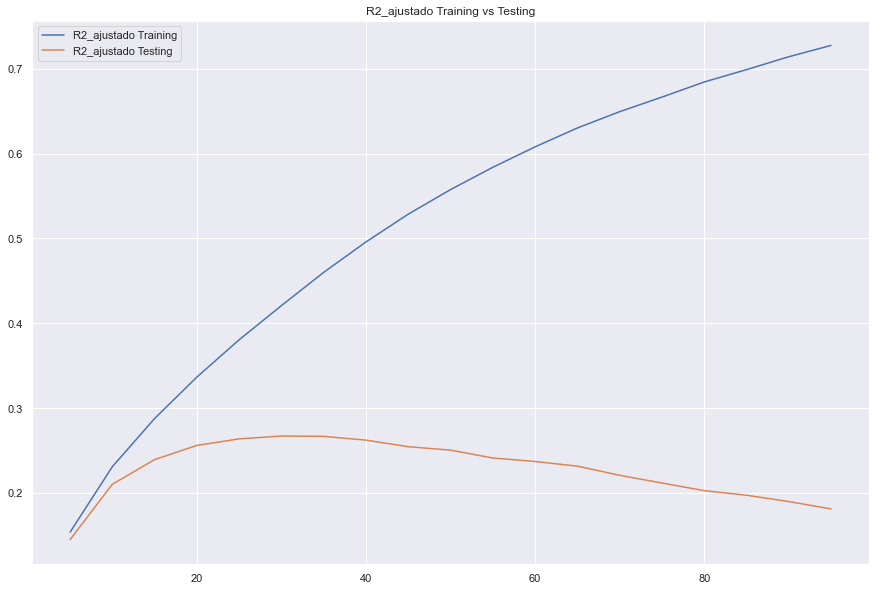

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(15,10))
plt.plot(range(5,100, 5), R2_ajustado_train, label='R2_ajustado Training')
plt.plot(range(5,100, 5), R2_ajustado_test, label='R2_ajustado Testing')
plt.ylim()
plt.legend(loc="best")
plt.title('R2_ajustado Training vs Testing')
plt.show()

**Como podemos ver el grupo de testeo alcanza un máximo para una profundidad de arbol igual a 30, osea es el punto de máxima reducción del sobreajuste. Veamos score arroja el modelo con este valor de hiperparámetro. 

In [100]:
# Cargo el regresor y realizo el entrenamiento
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn import tree
dtree1 = tree.DecisionTreeRegressor(max_depth=30)
dtree1.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=30)

In [101]:
from sklearn.metrics import r2_score
from sklearn import metrics
predictions_dtree1_train = dtree1.predict(X_train)
predictions_dtree1_test = dtree1.predict(X_test)
print ("R2_train: ", 1-(1-dtree1.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print ("R2_test: ", 1-(1-dtree1.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R2_train:  0.42072861376570647
R2_test:  0.2654538417963387


**Con el mejor valor del hiperparámetro se obtiene un desempeño muy bajo tanto para el grupo de testeo con en el de entrenamiento.** 

**VAMOS A PROBAR CON UN MODELO LINEAL DE REGRESIÓN. ESTOS MODELOS GENERAN MENOS SOBREAJUSTE A LOS DATOS DE ENTRENAMIENTO**

In [190]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

In [90]:
from sklearn.metrics import r2_score
from sklearn import metrics
predictions_reg_train = reg.predict(X_train)
predictions_reg_test = reg.predict(X_test)
print ("R2_train: ", 1-(1-reg.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print ("R2_test: ", 1-(1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R2_train:  0.4811367543441537
R2_test:  0.4686138622212177


**Como podemos ver, en el modelo de regresión lineal, se reduce el sobreajuste a los datos de entrenamiento y mejora el desempeño aunque sigue siendo bajo, osea, el error es alto.**

**Vamos a probar con un modelo de ensamble, el cual ensambla un gran número (variabilidad) árboles con poca profundidad o variabilidad, esto reduce el overfiting o sobreajuste.**

**Random Forest Regressor**

Dado que el algoritmo va trabajar con 1000 features elijo el hiperparámetro max_features='log2' para que trabaje con uina menor cantidad de features en cada ronda de endamble, esto ahorra mucho trabajo computacinal

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

In [107]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, max_features='log2')
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='log2', random_state=42)

In [98]:
from sklearn.metrics import r2_score
predictions_rf_train = rf.predict(X_train)
predictions_rf_test = rf.predict(X_test)

print ("R2_train: ", 1-(1-rf.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print ("R2_test: ", 1-(1-rf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R2_train:  0.8881194528793624
R2_test:  0.47307518041765395


**Con el modelo Random Forest solo mejora el desempeño del grupo de entrenamiento, osea genera un sobreajuste de los datos.** 

**AJUSTE DEL HIPERPARÁMETRO max_depth**

Text(0, 0.5, 'RMSE')

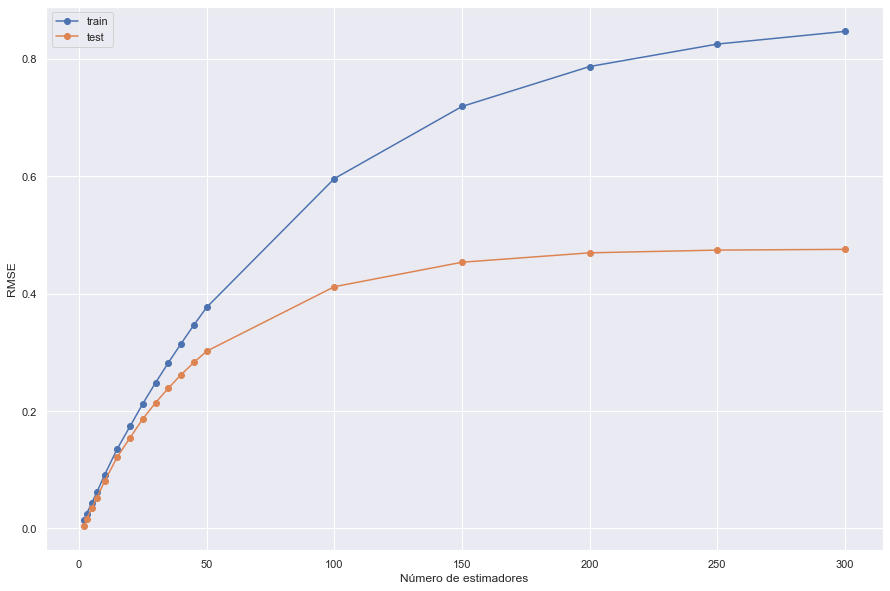

In [102]:
lista_R2_train = []
lista_R2_test = []

# Lista de valores de max_depth que vamos a explorar
max_depths = [2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250, 300]

# Loop sobre los distintos valores de profundidad 
for max_depth in max_depths:
    
    # Se repite el siguiente bloque de código
    
    # Defino el modelo con el valor de profundidad
    
    rf = RandomForestRegressor(random_state=42, max_features='log2', max_depth=max_depth)
    
    # Entreno el modelo
    rf.fit(X_train, y_train)
    
    # Predigo y evaluo sobre el set de entrenamiento
    predictions_rf_train = rf.predict(X_train)

    train_r2 = 1-(1-rf.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    
    # Predigo y evaluo sobre el set de evaluación
    predictions_rf_test = rf.predict(X_test)
    test_r2 = 1-(1-rf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    
    # Agrego la información a las listas
    lista_R2_train.append(train_r2)
    lista_R2_test.append(test_r2)
    
plt.figure(figsize=(15,10))
plt.plot(max_depths, lista_R2_train,'o-',label='train' )
plt.plot(max_depths, lista_R2_test,'o-',label='test')
plt.legend()
plt.xlabel('Profundidad del los árboles')
plt.ylabel('R2_ajustado')

**Como podemos ver la performance del grupo de testeo llega un máximo con una profundidad de 150. Sin embargo, esta performance sigue siendo baja. Veamos exactamente cual es la performance** 

In [102]:
from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor(random_state=42, max_features='log2', max_depth=150)
rf1.fit(X_train, y_train)

RandomForestRegressor(max_depth=150, max_features='log2', random_state=42)

In [103]:
from sklearn.metrics import r2_score
predictions_rf1_train = rf1.predict(X_train)
predictions_rf1_test = rf1.predict(X_test)

print ("R2_train: ", 1-(1-rf1.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print ("R2_test: ", 1-(1-rf1.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R2_train:  0.7188209635664586
R2_test:  0.4534866772191163


**Aunque se reduce la diferencia en desempeño entre los grupo sde testeo y entrenamiento, el desempeño general es más bajo. Por este motivo me quedo con el modelo sin optimizar.**

### **Análisis de distribución de errores y gráfico de relación de valores predichos vs los reales**

Dado los que resultados en la performance de los modelos. 

Modelo: DecisionTreeRegressor
R2 ajustado en Trained: -0.3547736765941083
R2 ajustado en Tested: -0.7242573544854864
Raíz del error cuadrático medio en Train: 1.072688899683499
Raíz del error cuadrático medio en Test: 1.2024030192088304


C:\Users\Gabriel\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gabriel\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


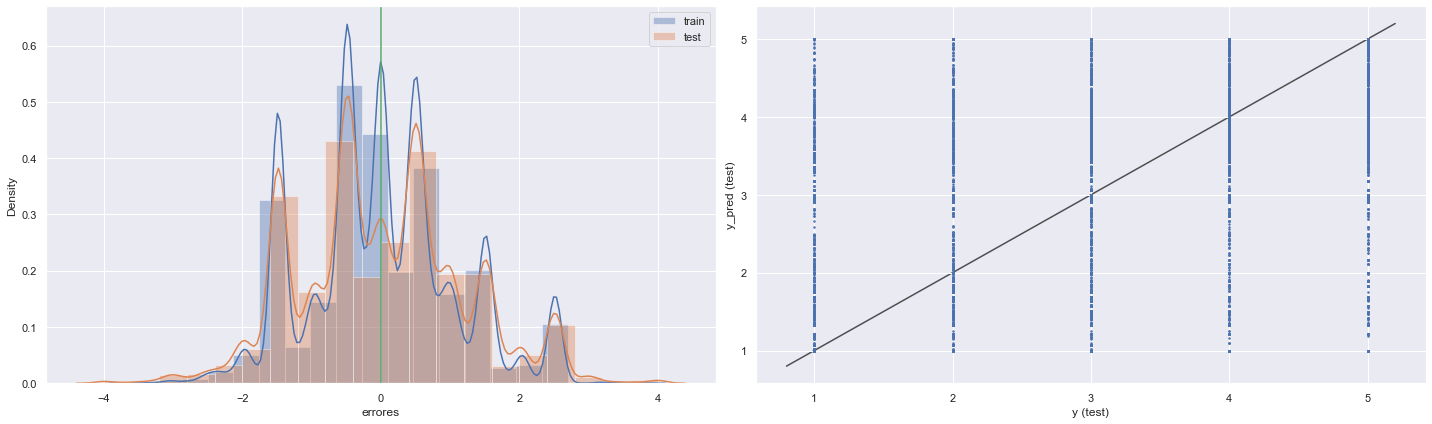

Modelo: LinearRegression
R2 ajustado en Trained: -0.06327460617574898
R2 ajustado en Tested: -0.07763814421380877
Raíz del error cuadrático medio en Train: 1.015217749747318
Raíz del error cuadrático medio en Test: 1.022693799035525


C:\Users\Gabriel\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gabriel\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


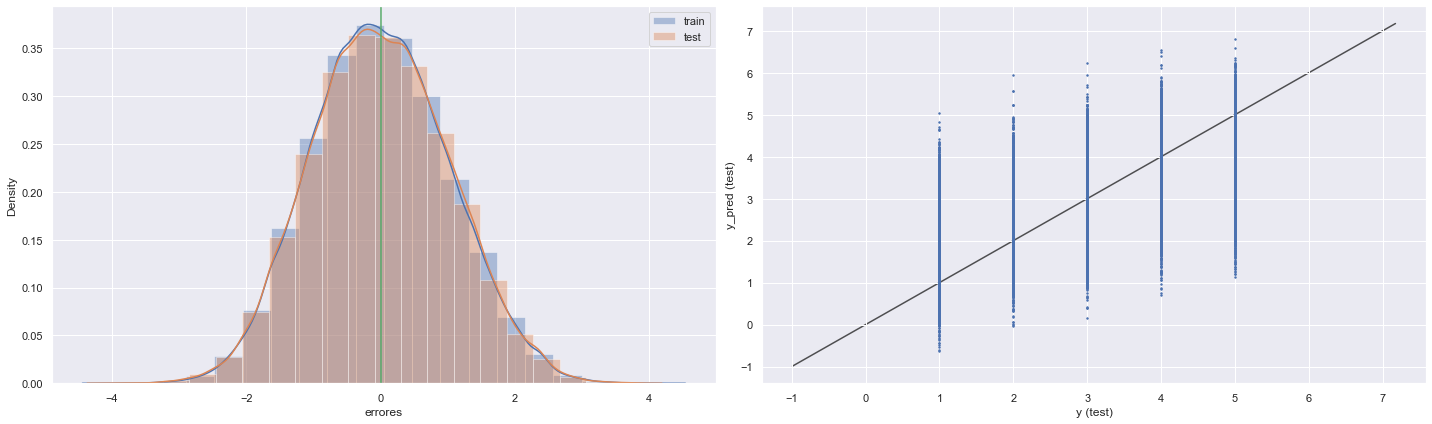

Modelo: RandomForestRegressor
R2 ajustado en Trained: 0.8264213695176456
R2 ajustado en Tested: -0.3422850060798095
Raíz del error cuadrático medio en Train: 0.4714222094594642
Raíz del error cuadrático medio en Test: 1.01839167395951


C:\Users\Gabriel\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gabriel\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


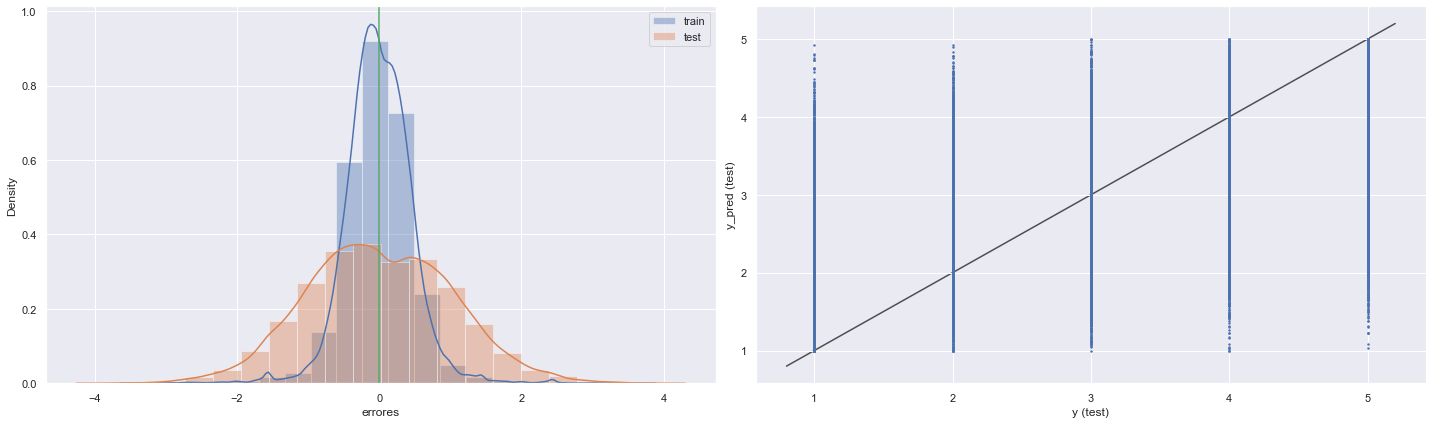

In [108]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns
modelos = ['DecisionTreeRegressor', 'LinearRegression','RandomForestRegressor']

for i, model in enumerate([dtree1, reg, rf]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')

    R2_ajustado_train = r2_score(y_train_pred, y_train)
    R2_ajustado_test = r2_score(y_test_pred, y_test)
    print(f'R2 ajustado en Trained: {R2_ajustado_train}')
    print(f'R2 ajustado en Tested: {R2_ajustado_test}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (20,6))
    
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.axvline(0, color='g')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

### Conclusiones de modelos de regresión 

**Análisis de distribución de errores** 
Como podemos ver el único modelo que tiene una distribución normal de errores es el de Regrasión Lineal

**Gráfico de relación de valores predichos vs los reales**

En este gráfico podemos por ejemplo que para el modelo Random Forest para calificaciones bajas (1 y 2) el modelo va a sobreestimar las calificaciones devolviendo valores superiores a los reales. Lo mismo, pero a la inversa ocurre con las calificaciones altas (4 y 5). Con el DecisionTreeRegresssor ocurre algo similar, el mejor de los modelos en este caso es nuevamente el de Regreasión Lineal donde los datos predichos están centrados y un poco más próximos a la recta identidad. 

**ANALISIS DE QUE QUEDARON PENDIENTES POR FALTA DE CAPACIDAD COMPUTACIONAL Y TIEMPO**

Búsqueda de los mejores hiperparámetros para el modelo Random Forest

In [ ]:
#import scipy as sp
#from scipy.stats import randint
#param_dist_rf = {'n_estimators': sp.stats.randint(100,800), 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth':sp.stats.randint(2,100)}

In [ ]:
#hyper_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=5, random_state=0)

In [ ]:
#hyper_rf.fit(X_train, y_train)  

In [ ]:
#print('Los mejores valores para los hiperparametros del algoritmo Random Forest Regressor son:'+str(hyper_rf.best_params_)) # Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.

In [ ]:
#print('El mejor Score que se obtiene a partir de estos hiperparámetros es:'+str(hyper_rf.best_score_)) # Mean cross-validated score of the best_estimator.

Support Vector Machines (SVM) se utiliza popular y ampliamente para los problemas de clasificación en el aprendizaje automático. Support Vector Regression (SVR) utiliza el mismo principio que SVM, pero para problemas de regresión. Podemos pensar en Support Vector Regression como la contraparte del SVM para problemas de regresión. SVR reconoce la presencia de no linealidad en los datos y proporciona un modelo de predicción competente.

In [ ]:
# from sklearn.svm import SVR
#regressor = SVR(kernel = 'rbf', C=1.0, epsilon=0.2, gamma='auto')
#regressor.fit(X_train,y_train)

In [ ]:
#from sklearn.metrics import r2_score
#predictions_svr_train = regressor.predict(X_train)
#predictions_svr_test = regressor.predict(X_test)
#print ("R2_train: ", r2_score(predictions_svr_train, y_train))
#print ("R2_test: ", r2_score(predictions_svr_test, y_test))

### 5. *Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?*

**A continuacion se presentan las palabras más importantes que el modelo utiliza para predecir.**

**REGRESIÓN LINEAL**

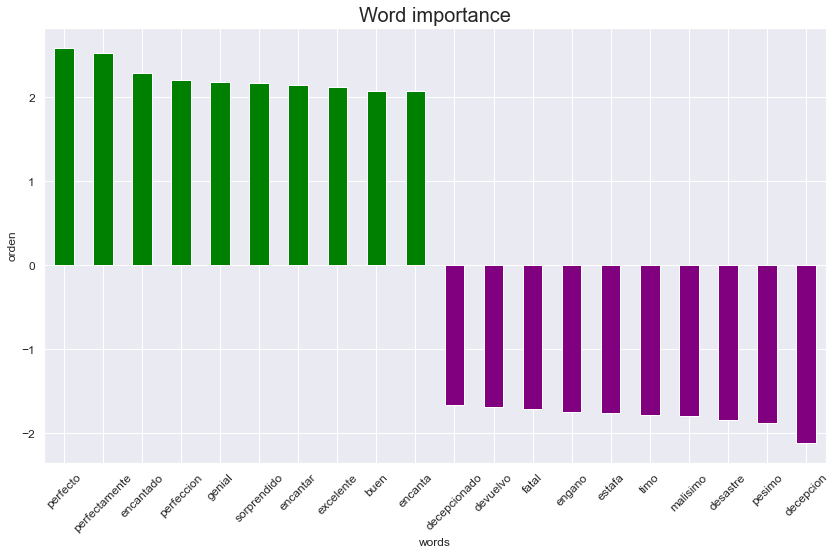

In [197]:
coeff =list(reg.coef_)
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'green', False: 'purple'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance',fontsize=20)
plt.show()

**A diferencia del modelo de clasificación SVC que me devuelve una liste de coeficientes por estrella (lo veremos más adelante), la Regresión Lineal solo me devuelve una lista de coeficientes y aparentemente por las palabras más importantes serían las que corresponden a la estrella 5. Si es así hay difiere un poco de las palabras seleccionadas por el modelo SCV, por ejemplo la segunda palabra en importancia es perfectamente en le modelo de Regresion y para el modelo SCV es encantado, lo cual me parece mejor porque perfecto y perfectamente es una redundancia. Veamos en el testeo si estas palabras pueden predecir la estrella correcta.**

## **Testeo del modelo de regresión lineal**

In [273]:
data

,stars,review_body,rev_lema,rev_corr
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",malisimo grande demasiado aparatoso protector ...,malisimo grande demasiado aparatoso protector ...
1,1,No he recibido el pedido no la devolución,recibido pedido devolucion,recibido pedido devolucion
2,1,"Tengo que buscar otro sistema, este no funcion...",buscar sistema funcionar bien abrazaderar llev...,buscar sistema funcionar bien abrazaderar agar...
3,1,Utilicé las brocas de menor diámetro y se me d...,utilizar broca menor diametro doblar varios ma...,utilizar broca menor diametro doblar varios ma...
4,1,No me gusta su olor a viejo y aspecto malo,gustar olor viejo aspecto malo,gustar olor viejo aspecto malo
...,...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,mando funcionar perfectamente cumplir todo fun...,mando funcionar perfectamente cumplir todo fun...
199996,5,"Compré la batería con cierta reticencia, pero ...",compre baterio cierto reticencia resulto facil...,baterio cierto reticencia resulto facil instal...
199997,5,Buena calidad. Satisfecha con la compra.,buen calidad satisfecho compra,buen calidad satisfecho
199998,5,Perfecto para el cumple de mi hijo,perfecto cumplir hijo,perfecto cumplir hijo


In [277]:
star_5= data[data.stars==5]
star_5.shape

(42000, 4)

In [278]:
star_5_test=star_5[:1000]

**VECTORIZACIÓN**

In [281]:
star_5 = list(star_5_test['rev_corr'].values)

**Preparamos el conversor de bag of words a vectores que traemos de sklearn.**

In [282]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features, ngram_range=(1, 2)) # stop_words="spanish" , ngram_range=(1, 2)
#cou_vec=TfidfVectorizer()

In [283]:
tfidf = TfidfVectorizer(max_features=1000,lowercase=False)

In [284]:
matriz_revs_5 = tfidf.fit_transform(star_5)

# Tomamos las palabras
all_words = tfidf.get_feature_names()

In [285]:
matriz_revs_5

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 7523 stored elements in Compressed Sparse Row format>

In [286]:
x_5 = matriz_revs_5.toarray()

In [288]:
pred_5_star=reg.predict(x_5)

In [289]:
len(pred_5_star)

1000

**Como podemos ver "pred_5_star" contiene las 1000 predicciones para calificaciones que sabemos que fueron de 5 estrellas, ahora veamos las predicciones**

In [290]:
pred_5_star

array([3.39567827, 2.4772076 , 2.80301781, 3.16487798, 1.94310498,
       3.15462494, 1.98332217, 3.81073496, 2.75038242, 2.10579698,
       3.19862443, 2.76247837, 3.20947263, 2.4685738 , 2.25572896,
       2.46190941, 1.45214591, 1.6667376 , 2.88317879, 2.52395423,
       3.12799939, 2.6328599 , 2.41856144, 4.31020435, 2.00812355,
       3.80655373, 3.55560057, 1.45769957, 2.03654434, 2.47567346,
       1.89515088, 2.02726374, 2.70610492, 3.27741821, 3.32537114,
       2.7773349 , 3.41909269, 3.27027161, 3.58769869, 2.63241691,
       3.2337905 , 1.14079324, 3.28907532, 1.53413013, 2.59168228,
       2.31953462, 1.09065279, 4.1092107 , 2.4874322 , 2.77821588,
       2.41856144, 4.23358495, 2.70723613, 2.99873389, 1.32358083,
       2.90166957, 1.98859601, 2.80612303, 3.01648912, 4.08874425,
       3.34377785, 2.95442012, 2.97487771, 3.39453694, 2.76844068,
       1.87543708, 2.94417352, 2.63231947, 3.38152263, 3.48712148,
       2.74396239, 2.39731632, 2.0423559 , 1.90773454, 2.72516

**Como podemos ver ninguna calificación es de 5. Veamos cuanto es el promedio.**

In [291]:
mean = sum(pred_5_star)/len(pred_5_star)
print(mean)

2.7263378087571724


**Como podemos ver este modelo tiene un gran error.**

### ¿ME EQUIVOQUÉ EN EL TIPO DE PROBLEMA? ¿SERÁ UN PROBLEMA DE CLASIFICACIÓN? VEAMOS COMO SE DESEMPEÑAN LOS MODELOS DE CLASIFICACIÓN

#### 2.  *Evalúa de forma apropiada sus resultados. Justifica la métrica elegida*

Dado que voy a evaluar modelos de clasificción y que el dataset se encuentra perfectamente balanceado voy a utlizar como métrica el Accuracy.

**Funcion para ver Confusion**

In [141]:
def confusion(y_test,y_test_pred,X):
    names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(8,8))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax, cmap='Blues')
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

####  3.  *Elige un modelo benchmark y compara tus resultados con este modelo.*

Como modelo benchmark utilizaré el algoritmo Gaussian Naive Bayes ya que es el modelo de clasificación menos complejo y sirve como base line para comparar el resultado con otros modelos.

**NB (Benchmark)**

In [139]:
nb = GaussianNB()
nb.fit(X_train,y_train)

y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train GaussianNB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test GaussianNB: ", accuracy_score(y_test, y_test_pred))

Accuracy train GaussianNB:  0.4132789115646259
Accuracy test GaussianNB:  0.3948412698412698


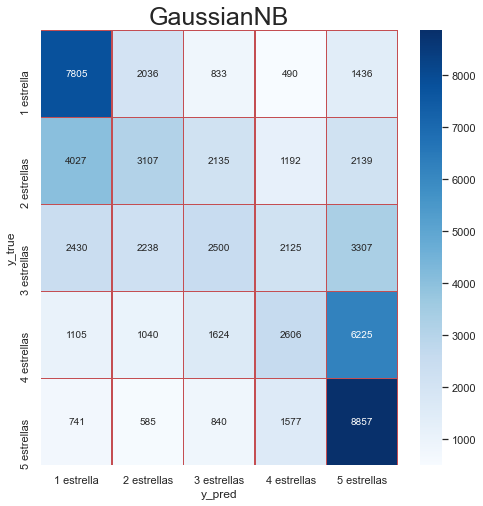

In [142]:
confusion(y_test,y_test_pred,"GaussianNB")

**Los valores que están sobre la diagonal descendente de izquierda a derecha son los verdaderos positivos, es notorio como el error de este algoritmo hace interpreta que un comentario corresponde a una estrella 5 cuendo en realidad es 4, lo mismo sucede con las estrellas 1 y 2, no tiene el nivel de sensibilidad para discriminrlas**

In [143]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.48      0.62      0.54     12600
           2       0.34      0.25      0.29     12600
           3       0.32      0.20      0.24     12600
           4       0.33      0.21      0.25     12600
           5       0.40      0.70      0.51     12600

    accuracy                           0.39     63000
   macro avg       0.37      0.39      0.37     63000
weighted avg       0.37      0.39      0.37     63000



**LinearSVC**

In [144]:
svc = LinearSVC(C = 1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.4772857142857143
Accuracy test LinearSVC:  0.4597301587301587


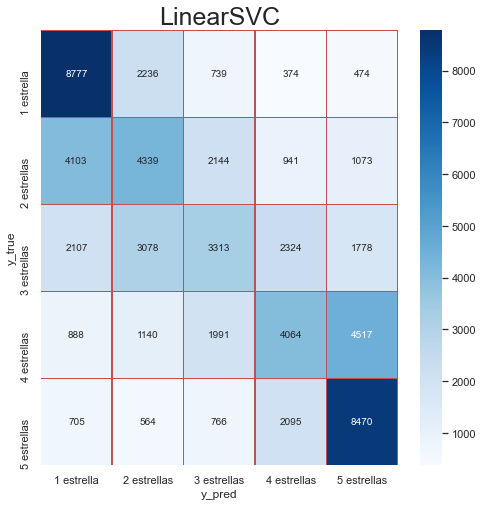

In [145]:
confusion(y_test,y_test_pred,"LinearSVC")

**Si bien con este modelo el error se reduce, ocurre lo algo similar a lo observado con el algoritmo NB. Los valores que están sobre la diagonal descendente de izquierda a derecha son los verdaderos positivos, es notorio como el error de este algoritmo hace interpreta que un comentario corresponde a una estrella 5 cuendo en realidad es 4, lo mismo sucede con las estrellas 1 y 2, no tiene el nivel de sensibilidad para discriminrlas**

In [146]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.53      0.70      0.60     12600
           2       0.38      0.34      0.36     12600
           3       0.37      0.26      0.31     12600
           4       0.41      0.32      0.36     12600
           5       0.52      0.67      0.59     12600

    accuracy                           0.46     63000
   macro avg       0.44      0.46      0.44     63000
weighted avg       0.44      0.46      0.44     63000



### 4. *Optimiza los hiperparámetros de tu modelo*

Se utiliza GridSearchCV para la optimizacion del LinerarSVC. Solo se trabajara con C.

**LinearSVC Optimizado con Randomizedsearch**

In [149]:
from sklearn.model_selection import RandomizedSearchCV
param_svc = {'C': [0.1,1,3,6] }  
  
hyper_svc = RandomizedSearchCV(svc, param_svc, n_iter=10, cv=5, random_state=0)

hyper_svc.fit(X_train, y_train)

C:\Users\Gabriel\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LinearSVC(C=1),
                   param_distributions={'C': [0.1, 1, 3, 6]}, random_state=0)

In [155]:
print(hyper_svc.best_estimator_)

LinearSVC(C=0.1)


In [156]:
print(hyper_svc.best_params_)

{'C': 0.1}


In [293]:
svc = LinearSVC(C = 0.1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.47693197278911564
Accuracy test LinearSVC:  0.459984126984127


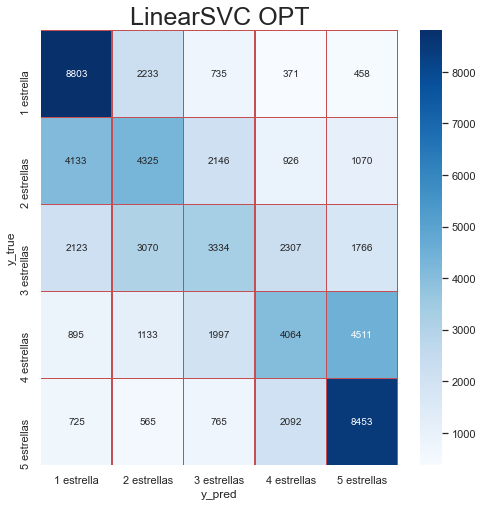

In [167]:
confusion(y_test,y_test_pred,"LinearSVC OPT")

No hay una mejora significativa

In [159]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.53      0.70      0.60     12600
           2       0.38      0.34      0.36     12600
           3       0.37      0.26      0.31     12600
           4       0.42      0.32      0.36     12600
           5       0.52      0.67      0.59     12600

    accuracy                           0.46     63000
   macro avg       0.44      0.46      0.44     63000
weighted avg       0.44      0.46      0.44     63000



In [160]:
gc.collect

<function gc.collect(generation=2)>

### 5. *Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?*

A continuacion se presentan las palabras que utiliza el LinearSVC para predecir según la etiqueta o estrella.

In [185]:
svc.coef_

array([[ 0.02801338,  0.24723604,  0.248302  , ..., -0.1780102 ,
         0.11627689, -0.12993189],
       [ 0.16088562,  0.13668349,  0.1683208 , ...,  0.01793982,
         0.00920441,  0.15451971],
       [-0.0011848 , -0.03194051, -0.04083563, ...,  0.00986058,
        -0.18666894,  0.20118966],
       [ 0.01935514, -0.14938133, -0.17304668, ...,  0.08411248,
        -0.09140496, -0.10535799],
       [-0.25252486, -0.346147  , -0.19297983, ...,  0.13350845,
         0.2935506 , -0.11922456]])

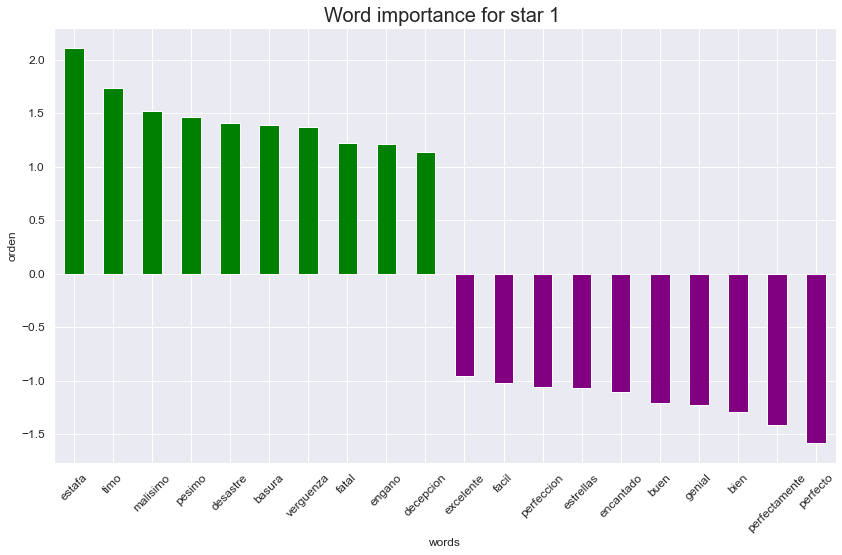

In [198]:
coeff = list(svc.coef_[0])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'green', False: 'purple'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 1 ',fontsize=20)
plt.show()

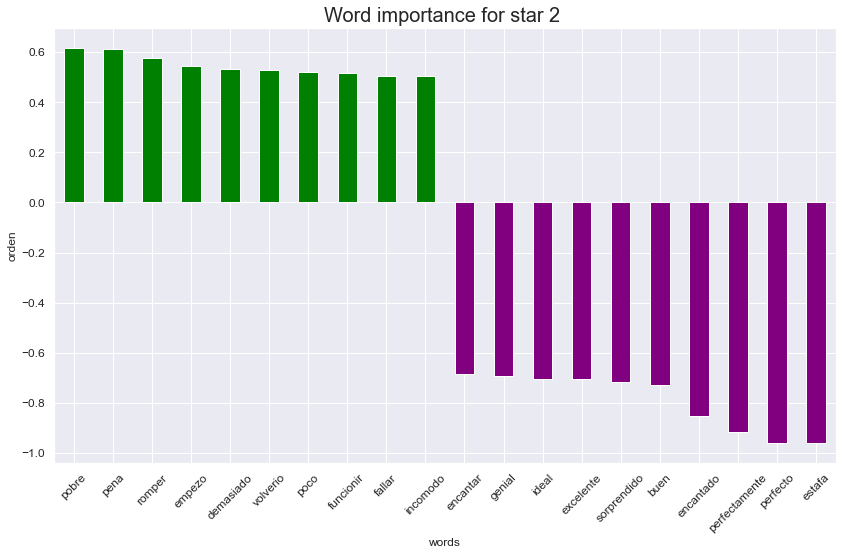

In [199]:
coeff = list(svc.coef_[1])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'green', False: 'purple'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 2 ',fontsize=20)
plt.show()

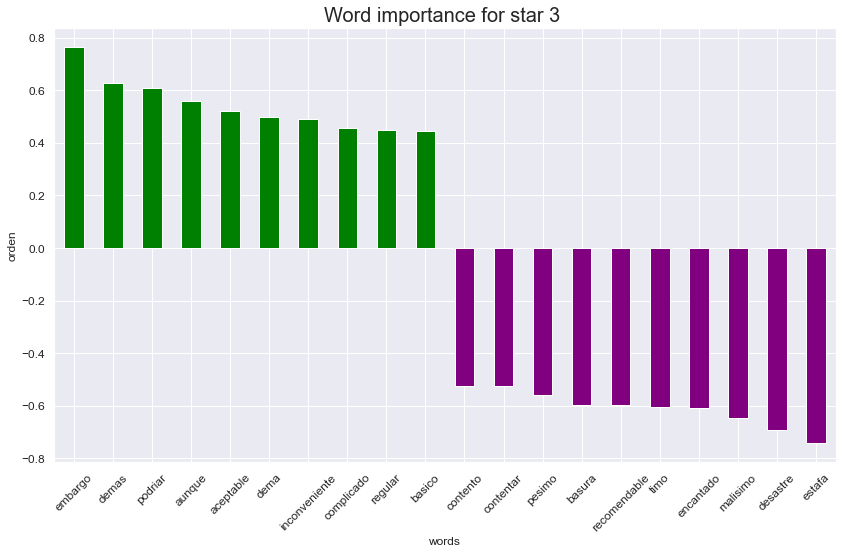

In [200]:
coeff = list(svc.coef_[2])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'green', False: 'purple'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 3 ',fontsize=20)
plt.show()

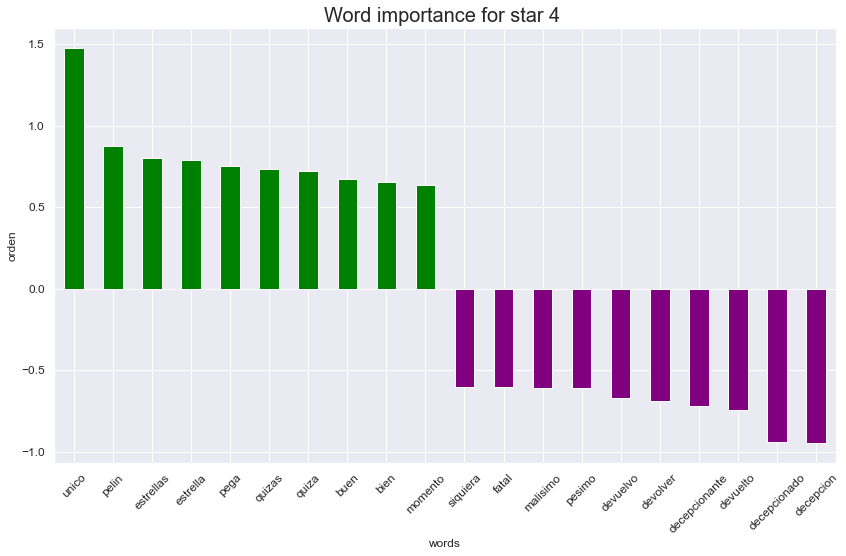

In [201]:
coeff = list(svc.coef_[3])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'green', False: 'purple'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 4 ',fontsize=20)
plt.show()

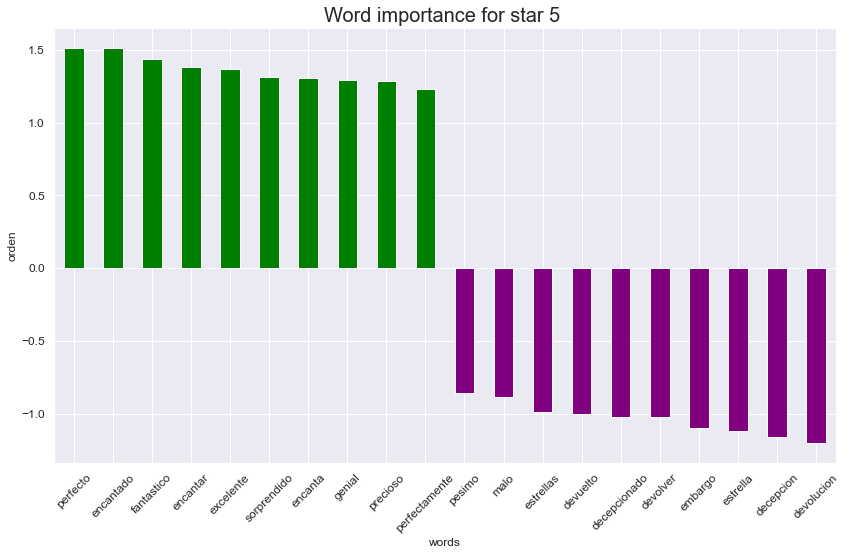

In [202]:
coeff = list(svc.coef_[4])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'green', False: 'purple'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 5 ',fontsize=20)
plt.show()

### **Como podemos observar, a pasar del bajo desempeño del algoritmo, este selecciona un grupo de palabras únicas para cada etiqueta. Las palabras seleccionadas son coherentes con la calificación o estrella correspondiente.**

## **Testeo del modelo de clasificación SVC**

In [299]:
pred_5_star_svc=svc.predict(x_5)

In [300]:
len(pred_5_star_svc)

1000

**Como podemos ver "pred_5_star" contiene las 1000 predicciones para calificaciones que sabemos que fueron de 5 estrellas, ahora veamos las predicciones**

In [301]:
pred_5_star_svc

array([4, 3, 1, 3, 1, 4, 1, 5, 2, 2, 5, 2, 5, 2, 1, 1, 2, 1, 1, 1, 4, 2,
       1, 5, 1, 4, 5, 1, 2, 1, 1, 2, 2, 5, 3, 1, 5, 4, 5, 1, 4, 1, 5, 1,
       2, 2, 1, 5, 2, 1, 1, 5, 2, 2, 1, 2, 1, 2, 2, 5, 5, 1, 3, 2, 5, 1,
       4, 1, 5, 4, 2, 1, 1, 2, 1, 2, 5, 5, 4, 4, 3, 1, 5, 1, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 1, 3, 5, 5, 1, 2, 2, 1, 1, 4, 3, 2, 2, 2, 2, 2, 1,
       5, 2, 5, 1, 2, 5, 1, 2, 2, 4, 4, 2, 1, 2, 4, 4, 2, 2, 1, 3, 2, 2,
       1, 2, 1, 2, 5, 1, 5, 5, 2, 5, 1, 2, 2, 2, 1, 2, 5, 1, 5, 2, 5, 1,
       2, 5, 2, 2, 2, 1, 2, 1, 4, 2, 2, 1, 2, 3, 4, 5, 1, 3, 1, 5, 1, 5,
       3, 2, 4, 2, 5, 1, 2, 2, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1,
       2, 1, 2, 5, 3, 2, 3, 5, 4, 3, 4, 1, 1, 1, 4, 2, 3, 1, 1, 2, 2, 1,
       4, 2, 2, 3, 2, 1, 2, 2, 4, 1, 1, 3, 2, 5, 1, 4, 1, 1, 3, 2, 1, 2,
       4, 1, 1, 2, 1, 4, 3, 1, 3, 2, 5, 2, 2, 3, 4, 2, 2, 5, 5, 4, 1, 2,
       2, 3, 2, 3, 5, 2, 1, 2, 5, 1, 1, 2, 2, 2, 2, 1, 1, 1, 4, 2, 5, 5,
       5, 2, 5, 3, 1, 2, 2, 1, 1, 1, 1, 5, 1, 3, 2,

**En este caso se pueden observar algunas calificaciones de 5. Veamos cuanto es el promedio.**

In [302]:
mean = sum(pred_5_star_svc)/len(pred_5_star_svc)
print(mean)

2.472


**Sin embargo, cuando hacemos el promedio vemos que se aleja más del valor real comparado con el valor obtenido en el caso del modelo de regresión lineal**

### **Conclusión final**

Si bien el modelo de regresión lineal tiene un poco menos de error que el modelo de clasifición, ambos modelos tienen una performance muy baja. Sería necesario aplicar otros modelos como GloVe o redes neuronales para ver si es posible lograr el objetivo de este trabajo que era predecir la calificación o estrella a partir del comentario o review. 
Nota:
GloVe: Vectores globales para la representación de palabras. Reformula las optimizaciones de word2vec como un tipo especial de factorialización para matrices de co-ocurrencia de palabras. 

### Para pensar, investigar y, opcionalmente, implementar

***¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?***

El análsis de sentimiento es útil para las empresas que saber que piensan sus compradores acerca de sus productos. A esto se le llama la retroalimentación del cliente. Este tipo de análisis es muy útil sobre todo para empresas de e-comence porqe disponen de un gran volumen de datos que les permite tomar acciones correctivas en su negocio antes de que las concecuencias sean irrevercibles (perdida masiva de clientes). También de las opiniones de los clientes se podría obtener información útil para innovar, desarrollar nuevos productos o mejorarlos. Ignorar es malo para el negocio.

El desempeño de los algoritmos utilizados en este tipo de análisis suele ser superior al obtenido en este proyecto ya que se trata de solo dos etiquetas. En el proyecto 3 el algoritmo tenia 5 etiquetas para predecir lo cual aumentaba mucho el error.

### ¿Que mejoraría en mi proyecto?

Como lo mencioné con anterioridad, hubieron análisis que quedaron pendientes por falta de capacidad computacional y de tiempo. Sería interesante probar el modelo de regresion SVM y tratar de seguir ajustanto los hiperparámetros de los modelos. También, me hubiese gustado aplicar el modelo Glove de google y un modelo de redes neuronales,  los cuales son mucho más potentes. En el proyecto 4 tengo pensado aplicar un análsis de sentimiento para comprobar si se obtiene un mejor resultado. 

**LINK AL REPOSITORIO DE GITHUB**

